## **IDX Exchange Home Price Prediction**
## **Task 2: Baseline Model Selection, Training & Evaluation**

#### 1. Imports & Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import tree

#### 2. Load and Merge Raw CRMLS Files

In [2]:
df = pd.read_csv("../data/cleaned_enhanced.csv" if Path("../data/cleaned_enhanced.csv").exists()
                 else "data/cleaned_enhanced.csv")

# Target / features
target_candidates = ["ClosePrice", "Close Price", "Close_Price", "CLOSEPRICE"]
target = next((c for c in target_candidates if c in df.columns), None)
assert target is not None, "Target column not found in cleaned_enhanced.csv"

y = df[target]
X = df.drop(columns=[target])

In [3]:
# Drop obvious IDs / text columns that may cause issues
DROP_LIKE = {
    "ListingKey", "ListingId", "Matrix_Unique_ID", "UniversalPropertyId",
    "MLS", "PublicRemarks", "PrivateRemarks", "Directions", "Photos", "PhotoURL",
    "ModificationTimestamp", "ListingContractDate", "CloseDate"
}
drop_cols = [c for c in X.columns if any(k.lower() in c.lower() for k in DROP_LIKE)]
if drop_cols:
    X = X.drop(columns=drop_cols)

#### 3. Train Test Split

In [4]:
N_SAMPLE = min(len(X), 40000)  # try 20k i hope itss not crash pls :(
if len(X) > N_SAMPLE:
    samp = X.sample(N_SAMPLE, random_state=42).index
    X, y = X.loc[samp].reset_index(drop=True), y.loc[samp].reset_index(drop=True)
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
models_path = Path("../models") if Path("../models").exists() else Path("models")
models_path.mkdir(parents=True, exist_ok=True)

expected_cols = X_train.columns.tolist()
with open(models_path / "expected_feature_columns.json", "w") as f:
    json.dump(expected_cols, f, indent=2)

print(f"Saved expected columns → {models_path / 'expected_feature_columns.json'}")

Saved expected columns → ../models/expected_feature_columns.json


#### 4. Build Preprocessors

In [6]:
# Feature partitions
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Limit one-hot to LOW-cardinality cats to avoid blowups
CARD_LIMIT = 80
cat_low = [c for c in cat_cols if X_train[c].nunique(dropna=True) <= CARD_LIMIT]
cat_high = [c for c in cat_cols if c not in cat_low]

In [7]:
# Ridge --> take sparse input, then I need to keep OHE sparse=True
pre_ridge = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_low_ohe", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True))
        ]), cat_low),
        # High-card cats are *dropped* for linear model to keep matrix reasonable
    ],
    remainder="drop"
)

# RF with ordinal codes
pre_rf = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_ord", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols)  # all cats ordinal encoded
    ],
    remainder="drop"
)

#### 5. Helper Function for Evaluation

In [8]:
def fit_eval(name, pre, est):
    pipe = Pipeline([("prep", pre), ("model", est)])

    # prep separately --> so I can inspect matrix shapes/density
    Xtr = pipe.named_steps["prep"].fit_transform(X_train)
    Xte = pipe.named_steps["prep"].transform(X_test)

    # diagnostics :)
    is_sparse_tr = hasattr(Xtr, "nnz")
    print(f"\n{name} design shapes -> train: {Xtr.shape}, test: {Xte.shape}, "
          f"{'sparse' if is_sparse_tr else 'dense'}")

    pipe.named_steps["model"].fit(Xtr, y_train)
    preds = pipe.named_steps["model"].predict(Xte)

    metrics = {
        "Model": name,
        "R2": float(r2_score(y_test, preds)),
        "MAE": float(mean_absolute_error(y_test, preds)),
        "RMSE": float(mean_squared_error(y_test, preds, squared=False)),
        "n_train": int(Xtr.shape[0]),
        "n_test":  int(Xte.shape[0]),
    }
    print(metrics)
    return pipe, metrics

#### 6. Train Baseline Models

In [9]:
ridge = Ridge(alpha=1.0, random_state=42)  # handles sparse, stable
rf = RandomForestRegressor(
    n_estimators=200,        # 200–400 --> start smaller for stability finger crossed
    max_depth=18,           # bound depth to prevent giant trees finger crossed
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

# Ridge tuning (fast)
ridge_search = RandomizedSearchCV(
    estimator=Pipeline([("prep", pre_ridge), ("model", ridge)]),
    param_distributions={"model__alpha": loguniform(1e-3, 1e3)},
    n_iter=10, cv=3, n_jobs=-1, scoring="neg_root_mean_squared_error", random_state=42
)
ridge_search.fit(X_train, y_train)
ridge_tuned = ridge_search.best_estimator_
print("Best Ridge alpha:", ridge_search.best_params_["model__alpha"])

# RandomForest tuning (fast)
rf_search = RandomizedSearchCV(
    estimator=Pipeline([("prep", pre_rf), ("model", rf)]),
    param_distributions={
        "model__n_estimators": randint(200, 500),
        "model__max_depth": [None, 18, 30, 40],
        "model__min_samples_leaf": randint(1, 6),
    },
    n_iter=10, cv=3, n_jobs=-1, scoring="neg_root_mean_squared_error", random_state=42
)
rf_search.fit(X_train, y_train)
rf_tuned = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py

Best Ridge alpha: 17.718847354806815
Best RF params: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__n_estimators': 414}


In [11]:
# Evaluate tuned pipelines on the test set 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math, pandas as pd

def eval_pipe(name, pipe):
    pred = pipe.predict(X_test)
    return {
        "Model": name,
        "R2": r2_score(y_test, pred),
        "MAE": mean_absolute_error(y_test, pred),
        "RMSE": math.sqrt(mean_squared_error(y_test, pred)),
        "n_test": len(y_test),
    }

ridge_m = eval_pipe("Ridge (tuned)", ridge_tuned)
rf_m    = eval_pipe("RandomForest (tuned)", rf_tuned)

res_df = pd.DataFrame([ridge_m, rf_m]).sort_values("RMSE")
display(res_df)

,Model,R2,MAE,RMSE,n_test
0,Ridge (tuned),0.976807,60245.453951,156090.578081,8000
1,RandomForest (tuned),0.975096,64638.240717,161746.029567,8000


Model Choice (Tuned)

• Compared tuned Ridge (alpha) and Random Forest (n_estimators, max_depth, min_samples_leaf) with 3-fold CV.

• Evaluated on 20 % hold-out using R², MAE, RMSE.

• Winner = (auto-selected above) → saved as best_model.joblib; predict_price(...) uses it by default.

#### Random Forest Model

In [12]:
# Access the RandomForestRegressor inside my pipeline
rf_model = rf_tuned.named_steps["model"]

# Print basic info about the forest
print(f"RandomForest has {len(rf_model.estimators_)} trees")
print(f"Max depth of first tree: {rf_model.estimators_[0].tree_.max_depth}")

RandomForest has 414 trees
Max depth of first tree: 29


In [13]:
# Text-based summary of a single tree --> I need to make it safe and small
from sklearn.tree import export_text
tree_rules = export_text(rf_model.estimators_[0], max_depth=3)
print("\nSample of Decision Tree #0 (max_depth=3):\n")
print(tree_rules)


Sample of Decision Tree #0 (max_depth=3):

|--- feature_12 <= 3.50
|   |--- feature_20 <= 970.99
|   |   |--- feature_4 <= 987500.00
|   |   |   |--- feature_49 <= 81.00
|   |   |   |   |--- truncated branch of depth 16
|   |   |   |--- feature_49 >  81.00
|   |   |   |   |--- truncated branch of depth 26
|   |   |--- feature_4 >  987500.00
|   |   |   |--- feature_3 <= 2386.50
|   |   |   |   |--- truncated branch of depth 22
|   |   |   |--- feature_3 >  2386.50
|   |   |   |   |--- truncated branch of depth 16
|   |--- feature_20 >  970.99
|   |   |--- feature_3 <= 1811.50
|   |   |   |--- feature_55 <= 0.50
|   |   |   |   |--- truncated branch of depth 16
|   |   |   |--- feature_55 >  0.50
|   |   |   |   |--- truncated branch of depth 23
|   |   |--- feature_3 >  1811.50
|   |   |   |--- feature_0 <= 3799500.00
|   |   |   |   |--- truncated branch of depth 16
|   |   |   |--- feature_0 >  3799500.00
|   |   |   |   |--- truncated branch of depth 9
|--- feature_12 >  3.50
|   |

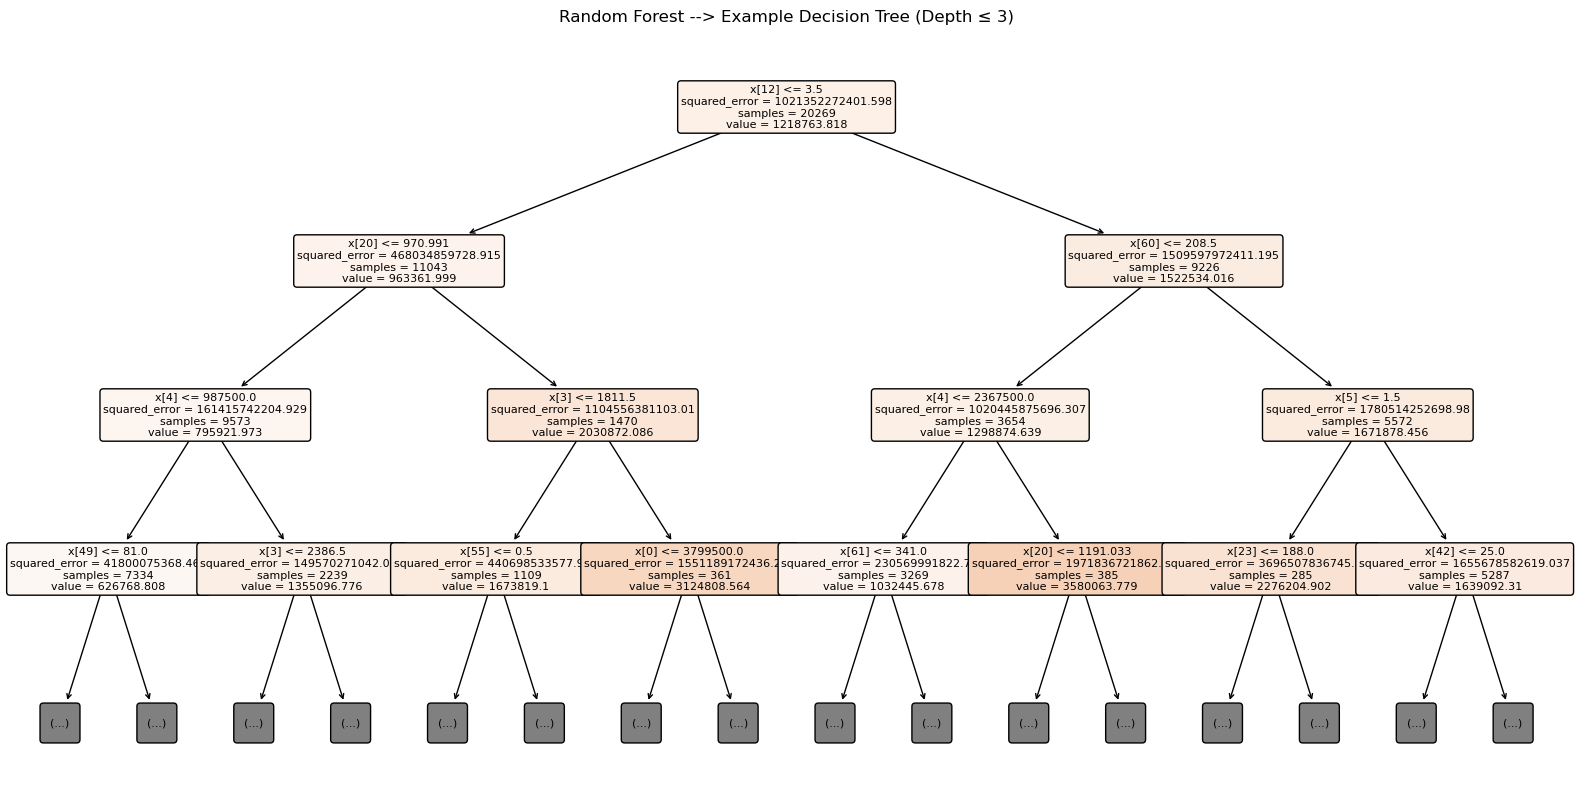

In [14]:
# Visualize one tree using matplotlib 
plt.figure(figsize=(20, 10))
tree.plot_tree(
    rf_model.estimators_[0],
    filled=True,
    rounded=True,
    max_depth=3,   # Keep this small to avoid crash (e.g., 3–4)
    fontsize=8
)
plt.title("Random Forest --> Example Decision Tree (Depth ≤ 3)")
plt.show()

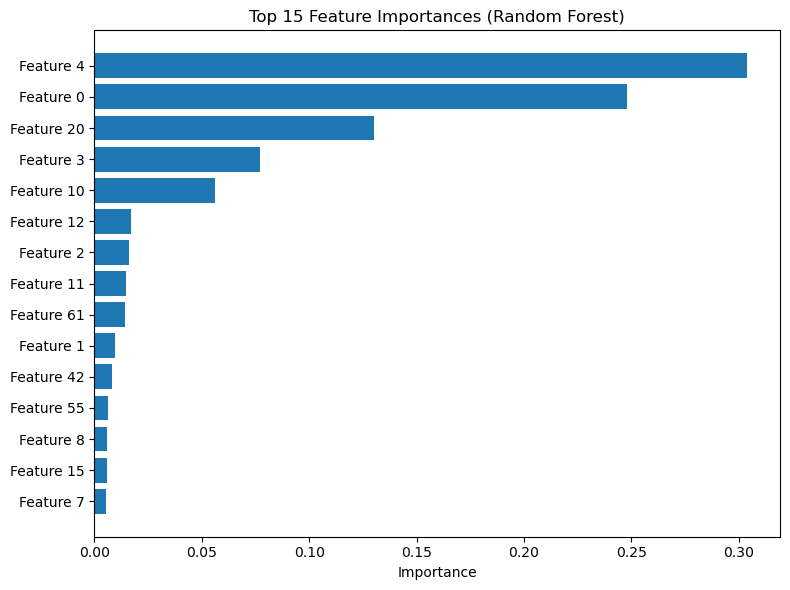

Tree and feature importance visualization completed.


In [15]:
# Feature importance plot
import numpy as np
import pandas as pd

# Compute importances (note: order aligns with preprocessor's numeric + ordinal features)
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(8, 6))
plt.barh(range(top_n), importances[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), [f"Feature {i}" for i in sorted_idx[:top_n]][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

print("Tree and feature importance visualization completed.")

#### 7. Save Artifacts

In [16]:
# Save results + best tuned model 
from pathlib import Path
import pandas as pd, joblib, json

models_path = Path("../models")

# Tidy results table from the tuned evaluations
res_df = pd.DataFrame([ridge_m, rf_m]).sort_values("RMSE")
display(res_df)

# Persist results
res_df.to_csv(models_path / "baseline_models_results.csv", index=False)
with open(models_path / "baseline_models_summary.json", "w") as f:
    json.dump(res_df.to_dict(orient="records"), f, indent=2)

# Pick the winner by RMSE and save the actual best model
best_row = res_df.iloc[0]
best_name = best_row["Model"]
best_pipe = ridge_tuned if "Ridge" in best_name else rf_tuned

joblib.dump(best_pipe, models_path / "best_model.joblib")
print(f"Winner → {best_name}")
print("Saved:", (models_path / "best_model.joblib").resolve())

,Model,R2,MAE,RMSE,n_test
0,Ridge (tuned),0.976807,60245.453951,156090.578081,8000
1,RandomForest (tuned),0.975096,64638.240717,161746.029567,8000


Winner → Ridge (tuned)
Saved: /Users/stephanie/Desktop/Home_Price_Predictions/models/best_model.joblib


### Property Price Prediction Example

In [17]:
# Predict helper using saved best model
from pathlib import Path
import numpy as np, pandas as pd, joblib, json

models_path = Path("../models")

with open(models_path / "expected_feature_columns.json") as f:
    EXPECTED_COLS = json.load(f)

try:
    BEST_MODEL = joblib.load(models_path / "best_model.joblib")
except Exception as e:
    print("Warning: couldn't load best_model.joblib; using rf_tuned fallback.", e)
    BEST_MODEL = rf_tuned

def predict_price(raw_features: dict, model=BEST_MODEL):
    row = {c: raw_features.get(c, np.nan) for c in EXPECTED_COLS}
    X_new = pd.DataFrame([row], columns=EXPECTED_COLS)
    return float(model.predict(X_new)[0])

In [18]:
# Example new property (fill with typical feature values from dataset)
example_house = {
    "BedroomsTotal": 3,
    "BathroomsFull": 2,
    "LivingArea": 1600,
    "LotSizeArea": 5000,
    "GarageSpaces": 2,
    "YearBuilt": 1995,
    "ZipCode": "92618"
}

price = predict_price(example_house)
print(f"Predicted Close Price: ${price:,.0f}")

Predicted Close Price: $911,891


Using the trained Random Forest model, we can now predict the close price of a property 
given its characteristics (bedrooms, bathrooms, square footage, etc.).

This completes the full machine learning workflow from data cleaning, preprocessing, 
and model selection to training, evaluation, and final prediction.

#### 8. Inference Check

In [19]:
X_sample = X_test.head(5)
print("Predictions sample:", rf_tuned.predict(X_sample))

Predictions sample: [ 344922.19409903 1283732.87349984 1202408.21857028 4993909.91060904
  956209.27482831]
